# Model Fitting: SGD

In [1]:
import numpy as np
import scipy.stats
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

/home/andys/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
player_info = pd.read_csv("clean-data/player_info.csv")
game_outcomes = pd.read_csv("clean-data/game_outcomes_15-16.csv")

In [3]:
player_info.head()

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg
0,Kobe Bryant,Los Angeles Lakers,25000000,SF,37,66,66,1863,10.7,30.0,...,5.6,6.7,5.0,1.7,0.4,3.5,3.1,31.3,95.0,113.0
1,Joe Johnson,Brooklyn Nets,24894863,SF,34,81,81,2703,7.1,16.1,...,4.6,5.5,6.0,1.1,0.1,3.0,2.7,18.6,104.0,113.0
2,LeBron James,Cleveland Cavaliers,22971000,SF,31,76,76,2709,14.0,26.9,...,8.6,10.7,9.8,2.0,0.9,4.7,2.7,36.5,116.0,103.0
3,Carmelo Anthony,New York Knicks,22875000,SF,31,72,72,2530,11.5,26.6,...,9.3,11.3,6.1,1.3,0.8,3.6,3.7,32.0,107.0,107.0
4,Dwight Howard,Houston Rockets,22359364,C,30,71,71,2280,8.0,12.9,...,12.9,18.0,2.1,1.5,2.4,3.6,4.7,21.0,111.0,104.0


In [4]:
game_outcomes.head(20)

,Visitor/Neutral,PTS,Home/Neutral,PTS.1,Year,diff
0,Detroit Pistons,106.0,Atlanta Hawks,94.0,2016,12.0
1,Cleveland Cavaliers,95.0,Chicago Bulls,97.0,2016,-2.0
2,New Orleans Pelicans,95.0,Golden State Warriors,111.0,2016,-16.0
3,Philadelphia 76ers,95.0,Boston Celtics,112.0,2016,-17.0
4,Chicago Bulls,115.0,Brooklyn Nets,100.0,2016,15.0
5,Utah Jazz,87.0,Detroit Pistons,92.0,2016,-5.0
6,Denver Nuggets,105.0,Houston Rockets,85.0,2016,20.0
7,Minnesota Timberwolves,112.0,Los Angeles Lakers,111.0,2016,1.0
8,Cleveland Cavaliers,106.0,Memphis Grizzlies,76.0,2016,30.0
9,Charlotte Hornets,94.0,Miami Heat,104.0,2016,-10.0


In [5]:
with open("clean-data/host_team_line_up.pkl", "rb") as f:
    host_team_line_up = pickle.load(f)

with open("clean-data/guest_team_line_up.pkl", "rb") as f:
    guest_team_line_up = pickle.load(f)

In [6]:
off_rating = player_info['PTS'].values
def_rating = player_info['DRtg'].values

In [7]:
player_info[player_info['ORtg'] > 130]

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg
248,Joel Anthony,Detroit Pistons,2500000,C,33,19,0,96,3.2,5.3,...,6.8,11.0,0.5,1.1,6.3,1.1,7.9,9.5,136.0,99.0
373,Rakeem Christmas,Indiana Pacers,1000000,PF,24,1,0,6,16.6,16.6,...,0.0,8.3,0.0,0.0,0.0,0.0,8.3,33.1,204.0,112.0
406,Jarnell Stokes,New Orleans Pelicans,845059,C,22,7,0,18,8.6,14.3,...,8.6,11.4,2.9,2.9,0.0,0.0,2.9,20.0,131.0,103.0


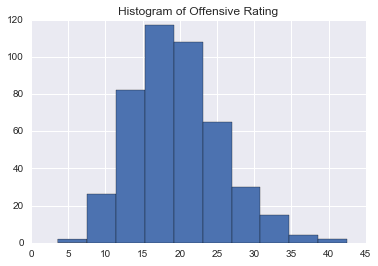

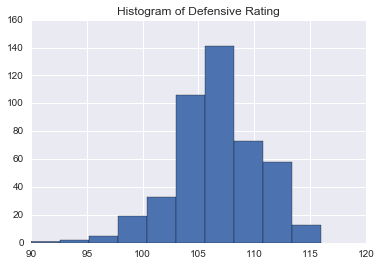

In [8]:
plt.hist(off_rating)
plt.title("Histogram of Offensive Rating")
plt.show()

plt.hist(def_rating)
plt.title("Histogram of Defensive Rating")
plt.show()

In [9]:
game_diff = game_outcomes['diff'].values

In [10]:
game_diff.shape

(1230,)

In [11]:
a = np.array([1,2,3,4])
b = a[:2]
b[0] = 5
print(a)

[5 2 3 4]


In [12]:
def loglik(coefs, game_diff, off_rating, def_rating, sigma_sq = 0.01):
    betas = coefs[0,:]
    gammas = coefs[1,:]
    ngames = game_diff.shape[0]
    loglik = 0
    
    for i in xrange(ngames):
        host_lineup = host_team_line_up[i]
        guest_lineup = guest_team_line_up[i]
        
        host_betas = betas[host_lineup]
        host_gammas = gammas[host_lineup]
        
        host_off = off_rating[host_lineup]
        host_def = def_rating[host_lineup]
        
        guest_betas = betas[guest_lineup]
        guest_gammas = gammas[guest_lineup]
        
        guest_off = off_rating[guest_lineup]
        guest_def = def_rating[guest_lineup]
        
        loglik += -(1.0/(2 * sigma_sq)) * ((game_diff[i] - np.dot(host_off, host_betas)
                                            - np.dot(guest_def, guest_gammas)
                                            - np.dot(guest_off, guest_betas)
                                            + np.dot(host_def, host_gammas))**2)
    return(loglik)

In [15]:
def sgd(game_diff, off_rating, def_rating, nplayers,
        nbatches = 100, sigma_sq = 1, learning_rate = 0.05,
        random_state = 0):
    '''
    Do stochastic gradient descent. Note that we need to -= 
    the gradient of the NEGATIVE log likelihood
    '''
    np.random.seed(random_state)
    betas = scipy.stats.norm.rvs(loc = 0, scale = 1, size = nplayers)
    gammas = scipy.stats.norm.rvs(loc = 0, scale = 1, size = nplayers)
    ngames = game_diff.shape[0]
    for b in xrange(nbatches):
        for i in xrange(ngames):
            #print(i)
            host_lineup = host_team_line_up[i]
            guest_lineup = guest_team_line_up[i]

            host_betas = betas[host_lineup]
            host_gammas = gammas[host_lineup]

            host_off = off_rating[host_lineup]
            host_def = def_rating[host_lineup]

            guest_betas = betas[guest_lineup]
            guest_gammas = gammas[guest_lineup]

            guest_off = off_rating[guest_lineup]
            guest_def = def_rating[guest_lineup]

            common_part = (1.0/(sigma_sq)) * (game_diff[i] - np.dot(guest_off, guest_betas)
                                                - np.dot(host_def, host_gammas)
                                                - np.dot(host_off, host_betas)
                                                + np.dot(guest_def, guest_gammas))
            guest_betas -= -learning_rate * guest_off * common_part
            host_betas -= learning_rate * host_off * common_part
            guest_gammas -= -learning_rate * guest_def * common_part
            host_gammas -= learning_rate * host_def * common_part
        
    return(betas, gammas)

In [19]:
betas, gammas = sgd(game_diff, off_rating, def_rating, player_info.shape[0], random_state=1262)
contribute_off = np.argsort(-betas * player_info['PTS'])
player_info.iloc[contribute_off].head(20)

,Player,Tm,2015-16,Pos,Age,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg
122,Jodie Meeks,Detroit Pistons,6270000,SG,28,3,0,43,8.2,23.5,...,4.7,5.9,3.5,0.0,0.0,1.2,2.3,25.8,111.0,111.0
28,Klay Thompson,Golden State Warriors,15500000,SG,25,80,80,2666,11.8,25.1,...,4.9,5.5,3.0,1.1,0.9,2.5,2.8,32.1,112.0,107.0
71,Jrue Holiday,New Orleans Pelicans,10595507,PG,25,65,23,1831,11.1,25.3,...,4.6,5.3,10.6,2.4,0.6,4.5,4.0,29.5,105.0,109.0
45,Eric Bledsoe,Phoenix Suns,13086957,PG,26,31,31,1059,10.3,22.6,...,4.9,5.8,8.7,2.9,0.9,5.1,3.5,29.1,107.0,107.0
31,Chandler Parsons,Dallas Mavericks,15361500,SF,27,61,51,1799,9.1,18.4,...,7.2,8.1,4.8,1.3,0.6,2.7,3.2,23.7,110.0,108.0
23,Tobias Harris,Detroit Pistons,16000000,PF,23,76,74,2513,8.3,17.7,...,8.3,10.2,3.4,1.3,0.8,2.2,3.1,22.3,112.0,107.0
285,Jusuf Nurkic,Denver Nuggets,1842000,C,21,32,3,547,9.3,22.2,...,10.1,16.0,3.7,2.2,4.0,5.0,8.3,24.1,92.0,102.0
19,Kawhi Leonard,San Antonio Spurs,16500000,SF,24,72,72,2380,11.9,23.4,...,8.6,10.6,4.0,2.8,1.5,2.3,2.9,32.8,121.0,96.0
124,Gerald Henderson,Portland Trail Blazers,6000000,SG,28,72,0,1431,8.1,18.5,...,6.3,7.4,2.6,1.4,0.7,2.4,3.0,21.8,104.0,109.0
56,Brandon Knight,Phoenix Suns,12000000,SG,24,52,50,1870,9.7,23.3,...,4.3,5.3,6.9,1.6,0.5,4.6,3.2,26.5,100.0,111.0


## Using L-BFGS